# Natural Language Processing with Deep Learning (7 points)

Today we're gonna apply the newly learned DL tools for sequence processing to the task of predicting job salary.

Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the assignment core (orignally written for theano/tensorflow).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download the data from __[here](https://yadi.sk/d/vVEOWPFY3NruT7)__.

You can also get it from the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (in that case, pick `Train_rev1.*`).


Our task is to predict one number, __SalaryNormalized__, in the sense of minimizing __Mean Absolute Error__.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

To do so, our model ca access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.


You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description).

In [2]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast nan to string

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
70064,68808719,Band 7 Podiatrist Jobs In Scotland,We are looking for an experienced Band 7 Podia...,Edinburgh and Lothians,UK,NaN,NaN,Castlerock Recruitment Group,Healthcare & Nursing Jobs,30 Per Hour,57600,jobsinscotland.com,10.961295
179681,71565134,Senior IT Recruitment Consultant (x ****),Senior IT Recruitment Consultant (x ****) ndsb...,Bristol Avon South West,UK,NaN,permanent,Berkeley Square IT,IT Jobs,25k - 30k,27500,cwjobs.co.uk,10.221977
60034,68692476,Central Secretary,My Cambridge based client is looking for a Sec...,Cambridge Cambridgeshire East Anglia,UK,NaN,permanent,Interaction Cambridge,Legal Jobs,18k per year,18000,totaljobs.com,9.798182


### The NLP part

To even begin training our neural network, we're gonna need to preprocess the text features: tokenize it and build the token vocabularies.

Since it is not an NLP course, we're gonna use simple built-in NLTK tokenization.

In [3]:
print("Before")
print(data["Title"][::100000])

Before
0         Engineering Systems Analyst
100000                   HR Assistant
200000           Senior EC&I Engineer
Name: Title, dtype: object


In [4]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

Now we can assume that our text is a space-separated list of tokens:

In [5]:
print("After")
print(data["Title"][::100000])

After
0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's see how many times is each word present in the data so that we can build a "white list" of known words.

In [25]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in "Title" and "FullDescription"
for text in list(map(lambda x: x.split(), list(data["Title"]))):
    token_counts.update(text)
for text in list(map(lambda x: x.split(), list(data["FullDescription"]))):
    token_counts.update(text)

In [26]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


Text(0.5, 0, 'Counts')

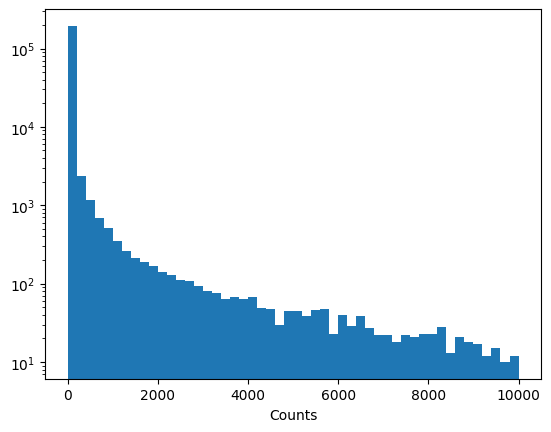

In [27]:
# Let's see how many words are there for each count

_=plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Counts")

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [28]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [key for key, value in token_counts.items() if value >= min_count]

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [29]:
print("Tokens left:", len(tokens))
assert type(tokens)==list
assert len(tokens) in range(32000,35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Tokens left: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [30]:
token_to_id = {element: idx for idx, element in enumerate(tokens)}

In [31]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into torch-digestible matrices.

In [32]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [33]:
#### print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[   2    3    4    1    1]
 [ 998  176    1    1    1]
 [  18 3472  242   59    6]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement tf-idf, target averaging or pseudo-counter-based encoding.

In [34]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

### The data science part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [35]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [36]:
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)
    
    batch = {}
    for col in text_columns:
        batch[col] = as_matrix(data[col].values, max_len)
    
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

In [64]:
generate_batch(data_train, 3, max_len=10)['Categorical'].shape

(3, 3768)

### Finally, let's talk deep learning

Out model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/Practical_DL/raw/master/homework04/conv_salary_architecture.png)

By default, both text vectorizers shall use 1d convolutions, followed by global pooling over time.

In [38]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]

In [49]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()
        self.relu = nn.ReLU()        
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv1(h)
        h = self.pool1(h)
        h =  self.relu(h)
        h = self.dense(h)
        
        return h

In [51]:
title_encoder = TitleEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['Title']))
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

Seems fine


__Task 2.1__ Create description encoder

In [57]:
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
class DescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        super().__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()
        self.relu = nn.ReLU()        
        self.dense = nn.Linear(out_size, out_size)
    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv1(h)
        h = self.pool1(h)
        h =  self.relu(h)
        h = self.dense(h)
        
        return h
    
        

In [58]:
desc_encoder = DescriptionEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['FullDescription']))
dummy_v = desc_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)
del desc_encoder
print("Seems fine too")

Seems fine too


__ Task 2.2__ Build one network ~~to rule them all~~

In [78]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(n_tokens=n_tokens, out_size=64)
        self.desc_encoder = DescriptionEncoder(out_size=64)
        
        # define layers for categorical features. A few dense layers would do.
        self.dense1 = nn.Linear(in_features=n_cat_features, out_features=64)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(in_features=64, out_features=64)
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.output = nn.Linear(in_features=3*64, out_features=1)
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = self.dense2(self.relu(self.dense1(cat_features)))
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        joint_h = self.output(joint_h)[:, 0]
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return joint_h

In [79]:
model = FullNetwork()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [80]:
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = Variable(torch.LongTensor(batch["Title"]))
desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
reference = Variable(torch.FloatTensor(batch[target_column]))

prediction = model(title_ix, desc_ix, cat_features)
assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [81]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()


In [82]:
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

### Let's train it!

In [83]:
from tqdm.notebook import tnrange 
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [84]:
num_epochs = 100
max_len = 100
batch_size = 32
batches_per_epoch = 100

In [85]:
for epoch_i in range(num_epochs):
    
    print("Training:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):

        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.numpy()
        train_mae += compute_mae(reference, prediction).data.numpy()
        train_batches += 1
    
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    
    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    with torch.no_grad():
        for batch in iterate_minibatches(data_val, shuffle=False):
            title_ix = Variable(torch.LongTensor(batch["Title"]))
            desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
            cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
            reference = Variable(torch.FloatTensor(batch[target_column]))

            prediction = model(title_ix, desc_ix, cat_features)
            loss = compute_loss(reference, prediction)

            val_loss += loss.data.numpy()
            val_mae += compute_mae(reference, prediction).data.numpy()
            val_batches += 1

    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')

Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	10.04787
	MAE:	33107.75946



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.75108
	MAE:	7104.05257



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.55052
	MAE:	6978.00842



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.46173
	MAE:	6650.45870



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.40836
	MAE:	6004.68770



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.37949
	MAE:	5069.30508



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.32798
	MAE:	5429.06323



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.29172
	MAE:	5086.30958



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.26250
	MAE:	4714.42154



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.25918
	MAE:	4566.08458



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.27176
	MAE:	4814.85529



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.23132
	MAE:	4505.25287



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.23777
	MAE:	4566.99536



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.21024
	MAE:	4162.88985



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.19391
	MAE:	4216.63633



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.19746
	MAE:	4146.38523



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.18614
	MAE:	3998.29790



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.18601
	MAE:	4040.79425



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.17881
	MAE:	3978.36409



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.17901
	MAE:	4054.61796



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.17312
	MAE:	3876.38502



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.17043
	MAE:	3964.99068



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.17398
	MAE:	3851.51022



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.18787
	MAE:	3846.78394



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.16445
	MAE:	3757.43988



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.16137
	MAE:	3928.69656



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.15357
	MAE:	3670.88250



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.15596
	MAE:	3830.13498



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.14730
	MAE:	3686.47272



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.15089
	MAE:	3524.90185



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.16376
	MAE:	3878.41428



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.16239
	MAE:	4123.01905



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.14096
	MAE:	3591.30254



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13535
	MAE:	3449.22995



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.13028
	MAE:	3471.88381



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13278
	MAE:	3483.70750



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.13484
	MAE:	3448.20648



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13039
	MAE:	3347.28370



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12151
	MAE:	3307.85136



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13034
	MAE:	3548.81285



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12441
	MAE:	3381.97999



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.12777
	MAE:	3301.49091



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12135
	MAE:	3380.25658



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.12497
	MAE:	3313.08860



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11021
	MAE:	3186.91832



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.12176
	MAE:	3388.11610



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11678
	MAE:	3306.13729



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11530
	MAE:	3229.99623



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11340
	MAE:	3258.74740



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11563
	MAE:	3300.94241



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12284
	MAE:	3438.68171



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.12256
	MAE:	3474.36120



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11536
	MAE:	3260.23048



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11758
	MAE:	3358.11493



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11138
	MAE:	3225.40291



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.12025
	MAE:	3212.99982



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11997
	MAE:	3264.03283



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11329
	MAE:	3147.20338



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10484
	MAE:	3091.44807



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11453
	MAE:	3352.60026



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12269
	MAE:	3332.81067



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11096
	MAE:	3243.45112



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11361
	MAE:	3195.65026



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11534
	MAE:	3383.04166



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10727
	MAE:	3121.75266



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10522
	MAE:	3052.47730



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09687
	MAE:	2932.81703



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10297
	MAE:	3063.65057



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10224
	MAE:	3075.69437



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10520
	MAE:	3165.26635



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10064
	MAE:	3153.23332



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10201
	MAE:	3019.70124



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11688
	MAE:	3383.37299



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11611
	MAE:	3148.47879



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10406
	MAE:	3120.60201



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11643
	MAE:	3406.55057



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10086
	MAE:	3085.35129



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.14849
	MAE:	3548.95876



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09971
	MAE:	2945.80691



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09883
	MAE:	2993.56510



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10414
	MAE:	3091.53369



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.12655
	MAE:	3287.31867



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10012
	MAE:	2942.63950



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09789
	MAE:	2937.48845



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10218
	MAE:	3059.51458



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09881
	MAE:	3020.45878



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09510
	MAE:	2997.73480



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09637
	MAE:	2978.80374



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11270
	MAE:	3337.04118



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11355
	MAE:	3342.74993



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09719
	MAE:	2952.89006



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13841
	MAE:	3961.57625



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09891
	MAE:	3035.44589



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09531
	MAE:	2924.49012



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08938
	MAE:	2876.92718



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10579
	MAE:	3252.35678



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09346
	MAE:	2930.86355



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09271
	MAE:	2904.82595



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09251
	MAE:	2959.70460



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10323
	MAE:	3012.07105



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08919
	MAE:	2915.27830



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09701
	MAE:	2915.82660



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09167
	MAE:	2841.39605



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09873
	MAE:	3110.51383



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09280
	MAE:	2885.17782



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09285
	MAE:	2931.81767



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09606
	MAE:	2977.37884



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09867
	MAE:	3092.38503



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08969
	MAE:	2852.17066



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09417
	MAE:	2991.33200



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08599
	MAE:	2810.31593



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10587
	MAE:	3311.43154



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08782
	MAE:	2861.37148



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.15992
	MAE:	3763.43381



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08939
	MAE:	2918.87948



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08958
	MAE:	2827.29569



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08687
	MAE:	2840.75966



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09097
	MAE:	2840.77527



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10266
	MAE:	3143.34627



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10531
	MAE:	3014.03332



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09184
	MAE:	2848.01347



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09310
	MAE:	2845.48742



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09766
	MAE:	2964.66488



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08751
	MAE:	2770.67964



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08498
	MAE:	2796.30300



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08756
	MAE:	2800.36979



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08789
	MAE:	2881.43841



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10371
	MAE:	3243.66506



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08280
	MAE:	2736.62888



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08587
	MAE:	2755.31427



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07958
	MAE:	2750.74551



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09895
	MAE:	2951.77110



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08702
	MAE:	2768.47917



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10124
	MAE:	2999.77190



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08921
	MAE:	2911.68243



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11503
	MAE:	3491.67959



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08645
	MAE:	2852.21933



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08494
	MAE:	2782.03856



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09298
	MAE:	2913.81122



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10993
	MAE:	3122.16050



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08557
	MAE:	2790.61910



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08624
	MAE:	2804.71572



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08575
	MAE:	2846.06047



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09314
	MAE:	2872.10836



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08753
	MAE:	2819.81015



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08458
	MAE:	2788.85928



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08014
	MAE:	2741.33587



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10236
	MAE:	3253.62155



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08403
	MAE:	2724.01787



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08916
	MAE:	2798.71293



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08080
	MAE:	2667.78222



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08776
	MAE:	2887.74105



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08283
	MAE:	2704.17749



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09942
	MAE:	2965.16990



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07895
	MAE:	2721.53386



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08609
	MAE:	2752.23074



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08864
	MAE:	2790.99684



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08670
	MAE:	2774.22071



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07398
	MAE:	2598.28112



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08476
	MAE:	2835.54319



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07828
	MAE:	2698.85323



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08712
	MAE:	2877.10239



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08017
	MAE:	2712.87946



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08248
	MAE:	2739.67676



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08522
	MAE:	2780.51549



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09887
	MAE:	3161.69110



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07199
	MAE:	2578.29024



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09940
	MAE:	2954.26808



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08360
	MAE:	2681.21889



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09014
	MAE:	2799.67292



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07973
	MAE:	2736.63035



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08477
	MAE:	2823.65398



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07944
	MAE:	2718.59378



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08953
	MAE:	2961.86122



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08094
	MAE:	2725.61536



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10071
	MAE:	2959.17901



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07423
	MAE:	2670.50395



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07848
	MAE:	2651.95689



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07402
	MAE:	2686.21396



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08232
	MAE:	2769.12751



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07592
	MAE:	2546.95419



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10535
	MAE:	3037.81839



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07955
	MAE:	2635.20913



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08017
	MAE:	2672.73806



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07659
	MAE:	2641.83727



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10186
	MAE:	2972.48091



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08211
	MAE:	2729.25046



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07865
	MAE:	2672.89441



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08448
	MAE:	2833.83374



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.12288
	MAE:	3274.34257



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08590
	MAE:	2795.39110



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07896
	MAE:	2663.12856



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08101
	MAE:	2816.34225



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09863
	MAE:	3232.03618



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08322
	MAE:	2754.08330



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07843
	MAE:	2674.10066



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07522
	MAE:	2621.28143



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07769
	MAE:	2672.15751



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07479
	MAE:	2589.22405



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08393
	MAE:	2717.14021





In [86]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

with torch.no_grad():
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.data.numpy()
        val_mae += compute_mae(reference, prediction).data.numpy()
        val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08393
	MAE:	2717.14021





### Task 3.2: Actually make it work

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__.

Try __at least 3 options__ from the list below for a passing grade. If you're into 

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm1d`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to do max pooling:
* Max over time - our `GlobalMaxPooling`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a small neural network


The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$

#### C) Fun with embeddings

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained word2vec from [here](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/) or [here](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/).
* Start with pre-trained embeddings, then fine-tune them with gradient descent
* Use the same embedding matrix in title and desc vectorizer

#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
  * Please bear in mind that while convolution uses [batch, units, time] dim order, 
    recurrent units are built for [batch, time, unit]. You may need to `torch.transpose`.

* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [keras](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L461) for inspiration.
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.state_dict`
  * Plotting learning curves is usually a good idea

### A short report

Please tell us what you did and how did it work.

`<YOUR_TEXT_HERE>`, i guess...